In this notebook, we construct an image denoising auto encoder. We'll first install some packages we'll need later on.

In [1]:
pip install -q bs4

In [2]:
pip install -q requests

In [3]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2DTranspose, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from glob import iglob
from bs4 import BeautifulSoup
import requests
import json
import urllib.parse
import os

This is the image we'll try to denoise:

In [4]:
url = 'http://mg.bluecourses.com/wp-content/uploads/2020/04/denoise.jpg'

In [5]:
def sk_load_img(url):
  return Image.fromarray(io.imread(url))

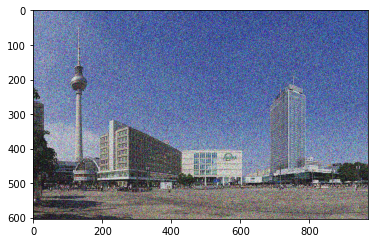

In [6]:
img = sk_load_img(url)
plt.imshow(img)
plt.show()

We'll also need a bunch of training images.

Since we don't have an easy set of "city" images available, we're just going to scrape some from Bing's image search, which is where the following two functions come in:

In [8]:
def get_soup(url, headers):
  return BeautifulSoup(requests.get(url, headers=headers).text, 'html.parser')

def get_images(query):
  url = "http://www.bing.com/images/search?q=" + query + "&FORM=HDRSC2"
  directory = 'photos/'
  headers = {'User-Agent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.134 Safari/537.36"}
  soup = get_soup(url, headers)
  if not os.path.exists(directory): os.mkdir(directory)
  for i, a in enumerate(soup.find_all("a", {"class":"iusc"})):
    m = json.loads(a['m'])
    raw_img = requests.get(m["turl"]).content
    f = open(directory + str(i) + '.jpg', 'wb')
    f.write(raw_img)
    f.close()

We can then scrape some using the query `city scape photo`:

In [9]:
get_images('city scape photo')

These aren't too many photos since we don't scrape all pages, but let's see what we get. Let's take a look at a random photo:

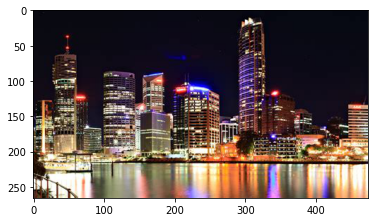

In [ ]:
example = sk_load_img('photos/20.jpg')
plt.imshow(example)
plt.show()

This isn't that bad, and is pretty similar to the image we started with. (Note: you might get a different set of images if you re-run this code.)

However, we do also need a noisified version to use as an input, so we're going to try to approach the original noise as well as possible:

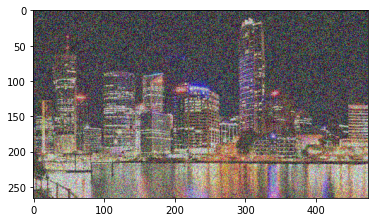

In [ ]:
ex_arr = image.img_to_array(example)
jitter = image.array_to_img(ex_arr + np.random.random_sample(ex_arr.shape)*255)
plt.imshow(jitter)
plt.show()

This is not too bad! We'll also create a preprocessing and deprocessing function:

In [ ]:
def preprocess_image(path, resize=False, add_jitter=False):
  image_original  = sk_load_img(path)
  image_processed = image_original.copy()
  if resize is not False: image_processed = image_processed.resize(resize)
  image_processed = image.img_to_array(image_processed)
  image_processed /= 255
  if add_jitter: image_processed += np.random.random_sample(image_processed.shape)
  return image_original, image_processed

def deprocess_image(arr):
  return image.array_to_img(arr)

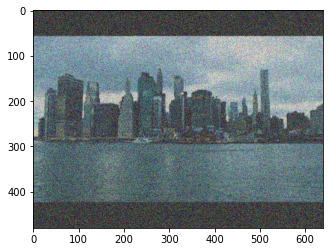

In [ ]:
img_size = (640, 480)

or_, pr_ = preprocess_image('photos/8.jpg', img_size, add_jitter=True)
plt.imshow(deprocess_image(pr_))
plt.show()

Again, keep in mind the difference between the resize argument `(width x height)` versus the Numpy array `(rows x cols x channels)`:

In [ ]:
pr_.shape, img_size

((480, 640, 3), (640, 480))

We now define our auto encoder, using convolutions and deconvolutions this time around. We use "same" padding everywhere, and make sure to use Kaiming He initialization, as it helps here:

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', input_shape=(img_size[1], img_size[0], 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))

model.add(Conv2DTranspose(8, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2DTranspose(16, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))

# This final layer convolves the filters back to three channels
model.add(Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same'))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 480, 640, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 480, 640, 8)       1160      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 480, 640, 8)       584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 480, 640, 16)      1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 480, 640, 3)       435       
Total params: 3,795
Trainable params: 3,795
Non-trainable params: 0
_________________________________________________________________


Next, we define a helper function to create a batch of training instances:

In [ ]:
def make_image_batch():
  X, Y = [], []
  for path in iglob('./photos/*.jpg'):
    _, Xpr_ = preprocess_image(path, img_size, True)
    _, Ypr_ = preprocess_image(path, img_size, False)
    X.append(Xpr_)
    Y.append(Ypr_)
  return np.array(X), np.array(Y)

Next, we train over a couple of epochs. Within each inner epoch, we fit for ten epochs on the current batch of images. Why do it this way and call `make_image_batch()` every time? This is due to the fact that we want to have a different random jitter every outer epoch, in order to add in more input variety during training (otherwise, we're very likely to overfit on the data).

Every so often, we also show how well we're doing so far.

Epoch 0 loss = 0.10688894242048264


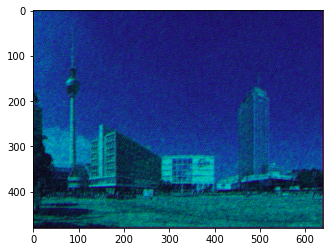

Epoch 5 loss = 0.013594252057373524


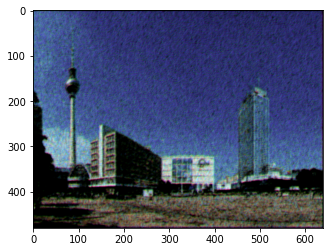

Epoch 10 loss = 0.008834045380353928


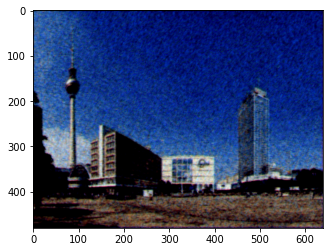

Epoch 15 loss = 0.006981463171541691


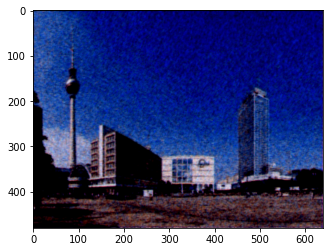

Epoch 20 loss = 0.006152579560875893


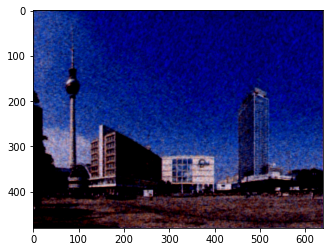

Epoch 25 loss = 0.005495686549693346


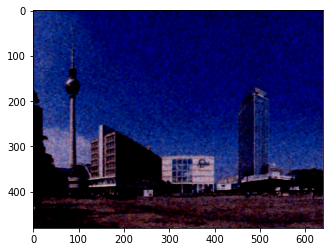

Epoch 30 loss = 0.0049467384815216064


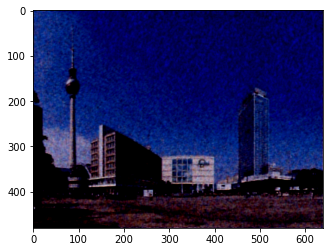

Epoch 35 loss = 0.004820787813514471


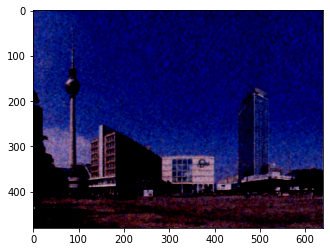

Epoch 40 loss = 0.0045327553525567055


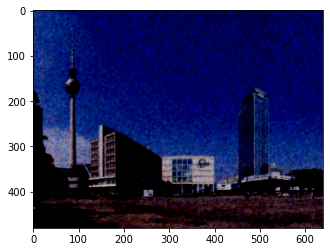

Epoch 45 loss = 0.00443806778639555


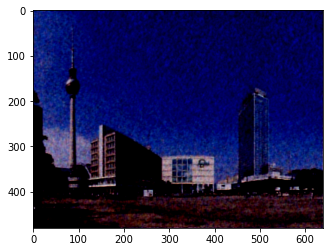

In [ ]:
batch_size = 32
epochs     = 50

for epoch in range(epochs):
  X_train, Y_train = make_image_batch()
  hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=0)

  if epoch % 5 == 0:
    print('Epoch', epoch, 'loss =', hist.history['loss'][-1])
    img_o, img_p = preprocess_image(url, img_size, False)
    img_predicted = model.predict(np.expand_dims(img_p, axis=0))
    plt.imshow(deprocess_image(img_predicted[0]))
    plt.show()

This works well, but our image does get darker as we train more. Think about why this is and what we could do to fix this. Would training more help? Adding more images? Regularization? Going for a deeper architecture? Image augmentation?

Finally, let's see how well our network does on one of the training images:

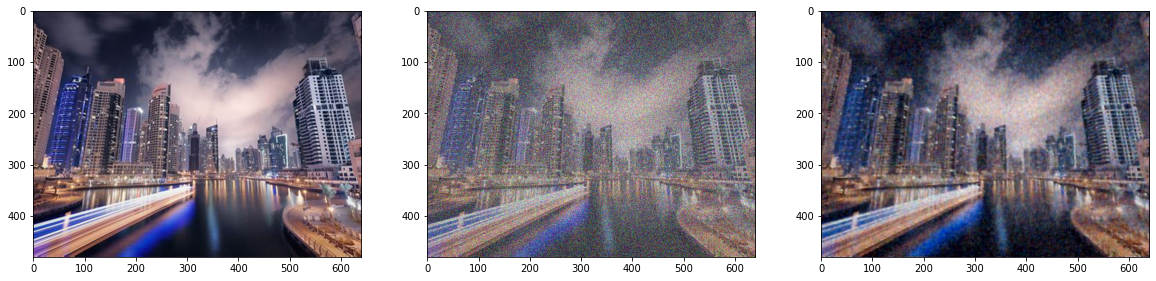

In [ ]:
_, original  = preprocess_image('photos/2.jpg', img_size, add_jitter=False)
_, processed = preprocess_image('photos/2.jpg', img_size, add_jitter=True)
predicted    = model.predict(np.expand_dims(processed, axis=0))[0]

fix, ax = plt.subplots(1,3, figsize=(20, 10))
ax[0].imshow(deprocess_image(original))
ax[1].imshow(deprocess_image(processed))
ax[2].imshow(deprocess_image(predicted))

plt.show()